In [1]:
import os
from tensorflow.python.client import device_lib

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11458715717288881439
]


In [2]:
from glob import glob
import re
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches


In [3]:
from data_loader import alphabet as alphabet
from crnn_model import CRNN
from data_loader import load_data

Using TensorFlow backend.


In [4]:
from SROCR import build_generator as srocr_gen

In [5]:
input_width = 256
#input_width = 1024
input_height = 32
input_shape = (input_width, input_height, 1)


In [6]:
def decode(chars):
    blank_char = '_'
    new = ''
    last = blank_char
    for c in chars:
        if (last == blank_char or last != c) and c != blank_char:
            new += c
        last = c
    return new

Import SRGAN generator trained for super-resolution

In [7]:
SROCR_gen_1x = srocr_gen([None,None, 1],2)
SROCR_gen_1x.load_weights('srocr_1xgen\generator_srocr.h5')

In [8]:
srocr_crnn_1x = CRNN(input_shape, len(alphabet))
srocr_crnn_1x.load_weights('srocr_1xgen\crnn_srocr.h5')

In [9]:
SROCR_gen_4x = srocr_gen([None,None, 1],2)
SROCR_gen_4x.load_weights('srocr_4xgen\generator_srocr.h5')

In [10]:
srocr_crnn_4x = CRNN(input_shape, len(alphabet))
srocr_crnn_4x.load_weights('srocr_4xgen\crnn_srocr.h5')

In [11]:
SROCR_gen_10x = srocr_gen([None,None, 1],2)
SROCR_gen_10x.load_weights('srocr_10xgen\generator_srocr.h5')

In [12]:
srocr_crnn_10x = CRNN(input_shape, len(alphabet))
srocr_crnn_10x.load_weights('srocr_10xgen\crnn_srocr.h5')

In [13]:
#Import test images and ground truth

imgdir = 'C:/Users/surao/Desktop/Sudhu/Dataset/LHT_AERO_ALZEY_DATA/test_images'
gtdir = 'C:/Users/surao/Desktop/Sudhu/Dataset/LHT_AERO_ALZEY_DATA/test_gt'

high_reso,low_reso,labels,input_length,label_length,source_str = load_data(imgdir,gtdir)

# SROCR from LR images

The following section shows result of the output of generator, when a low resolution input is provided.

In [14]:
def get_random_crop(image, crop_height, crop_width):


    max_x = image.shape[1] - crop_width
    max_y = image.shape[0] - crop_height

    x = np.random.randint(0, max_x)
    y = np.random.randint(0, 100)

    crop = image[y: y + crop_height, x: x + crop_width]

    return crop,x,y

In [15]:
def plot_gan_zoom(G,name):
    crop_height = 64
    crop_width = 24
    fig = plt.figure(figsize=(12, 12))
    fig.set_tight_layout({"pad": .0})

    idx = np.random.randint(0, low_reso.shape[0] - 1)
    img_tmp = cv2.resize(low_reso[idx], (32, 256))
    img_hrp,x,y = get_random_crop(img_tmp, crop_height, crop_width)

    

    rect = patches.Rectangle((x,y),crop_height,crop_width,linewidth=1,edgecolor='r',facecolor='none')
    rect1 = patches.Rectangle((x,y),crop_height,crop_width,linewidth=1,edgecolor='r',facecolor='none')

    ax1  = fig.add_subplot(2, 2, 1)
    ax1.add_patch(rect)    
    #img_tmp = np.squeeze(img_tmp, axis=2)
    plt.imshow(img_tmp.transpose(1,0),cmap='gray')
    plt.grid('off')
    plt.axis('off')
    plt.title('bicubic')


    ax4  = fig.add_subplot(2, 2, 3)
    plt.imshow(img_hrp.transpose(1,0),cmap='gray')
    plt.grid('off')
    plt.axis('off')
    plt.title('bicubic')

    img = G.predict(np.expand_dims(low_reso[idx], axis=0) / 127.5 - 1)
    img_unnorm = (img + 1) * 127.5
    ax3  = fig.add_subplot(2, 2, 2)
    ax3.add_patch(rect1)
    img_gan = np.squeeze(img_unnorm, axis=0).astype(np.uint8)
    img_gan = np.squeeze(img_gan, axis=2)
    plt.imshow(img_gan.transpose(1,0),cmap='gray')

    #plt.imshow(img_gan)
    plt.grid('off')
    plt.axis('off')
    plt.title(name)


    ax6  = fig.add_subplot(2, 2, 4)
    plt.imshow(img_gan[y: y + crop_height, x: x + crop_width].transpose(1,0),cmap='gray')
    plt.grid('off')
    plt.axis('off')
    plt.title(name)

In [16]:
def plot_srocr(G,ocr,name):
    n_imgs=4
    plt.figure(figsize=(12, 12))
    plt.tight_layout({"pad": .0})
    for i in range(0, n_imgs * 2, 2):
        idx = np.random.randint(0, low_reso.shape[0] - 1)
        plt.subplot(n_imgs, 2, i + 1)
        img_tmp = cv2.resize(low_reso[idx], (32, 256))
        plt.imshow(img_tmp.transpose(1,0),cmap='gray')
        plt.grid('off')
        plt.axis('off')
        plt.title('LR image ({})'.format(source_str[idx]))
    

        img = G.predict(np.expand_dims(low_reso[idx], axis=0) / 127.5 - 1)
        img_unnorm = (img + 1) * 127.5
        img_gan = np.squeeze(img_unnorm, axis=0).astype(np.uint8)
        img_gan = np.squeeze(img_gan, axis=2)
        plt.subplot(n_imgs, 2, i + 2)
        plt.imshow(img_gan.transpose(1,0),cmap='gray')  
        
        res = ocr.predict(img_unnorm)

        for i in range(len(res)):

            # best path, real ocr applications use beam search with dictionary and language model
            chars = [alphabet[c] for c in np.argmax(res[i], axis=1)]
            res_str = decode(chars)
    
        plt.grid('off')
        plt.axis('off')
        plt.title(name+ '({})'.format(res_str))

#### SROCR (learning rate from OCR = learning rate from SR) 

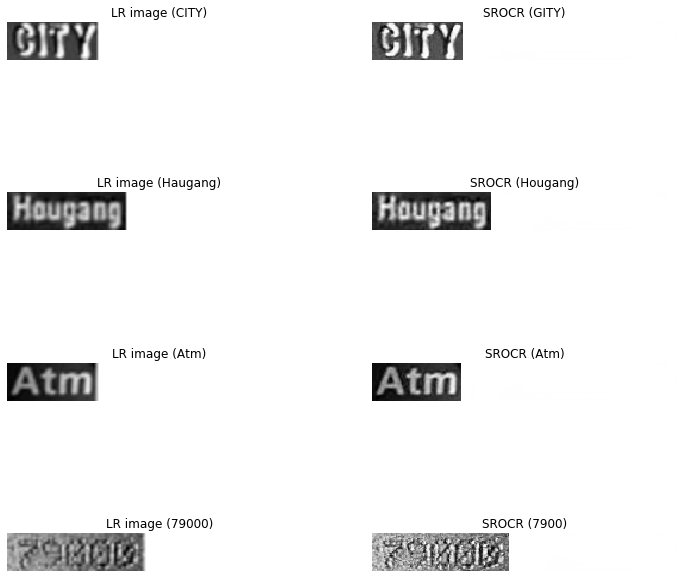

In [26]:
plot_srocr(SROCR_gen_1x,srocr_crnn_1x,'SROCR ')

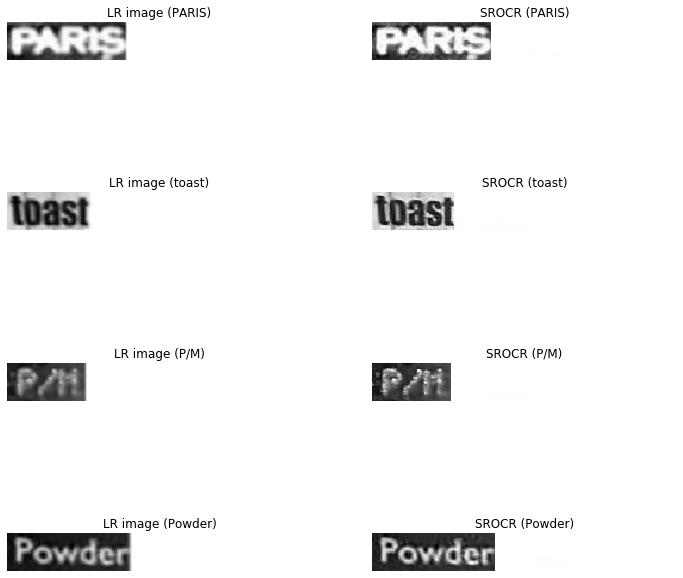

In [27]:
plot_srocr(SROCR_gen_1x,srocr_crnn_1x,'SROCR ')

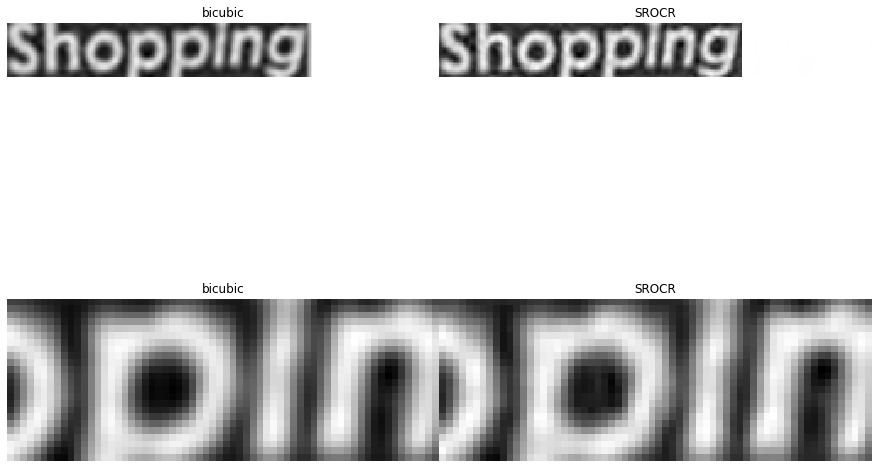

In [36]:
plot_gan_zoom(SROCR_gen_1x,'SROCR')

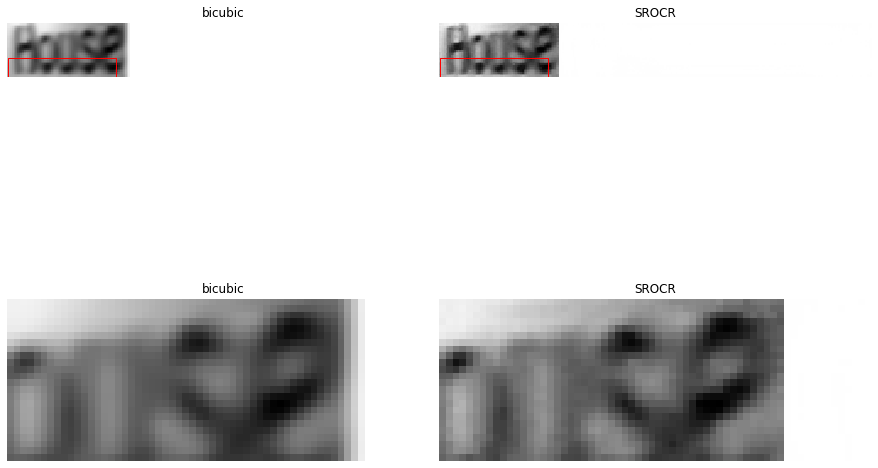

In [37]:
plot_gan_zoom(SROCR_gen_1x,'SROCR')

#### SROCR (learning rate from OCR = 4 x learning rate from SR)  

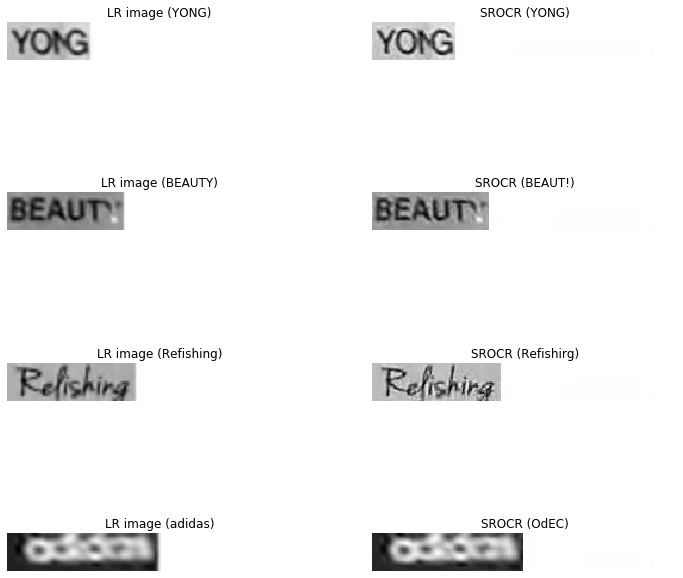

In [28]:
plot_srocr(SROCR_gen_4x,srocr_crnn_4x,'SROCR ')

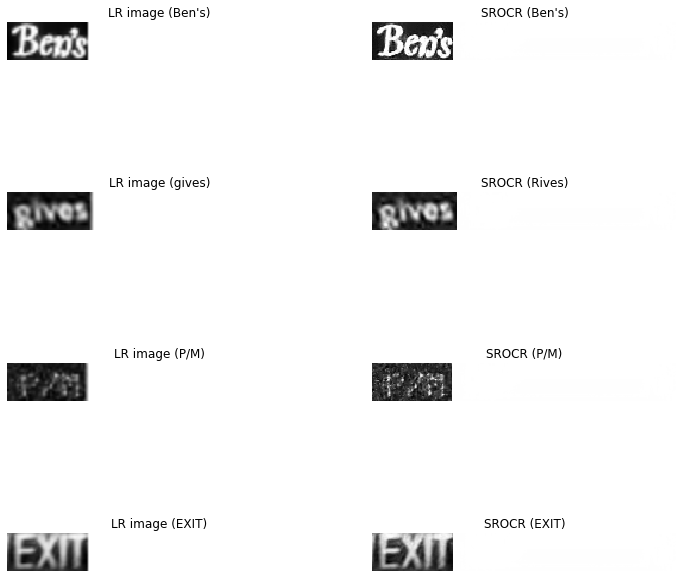

In [29]:
plot_srocr(SROCR_gen_4x,srocr_crnn_4x,'SROCR ')

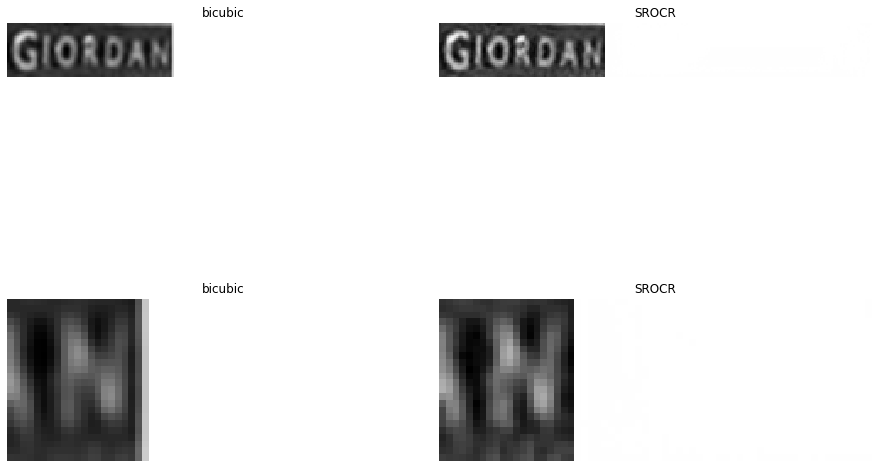

In [39]:
plot_gan_zoom(SROCR_gen_4x,'SROCR')

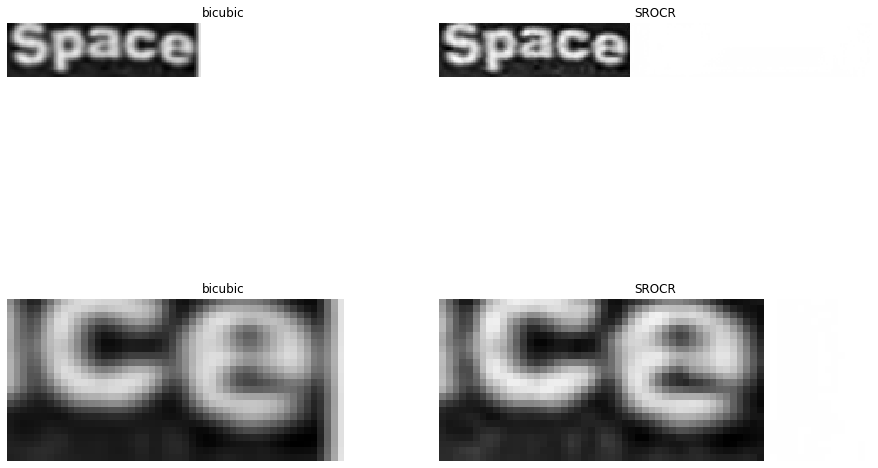

In [40]:
plot_gan_zoom(SROCR_gen_4x,'SROCR')

#### SROCR (learning rate from OCR = 10 x learning rate from SR)  

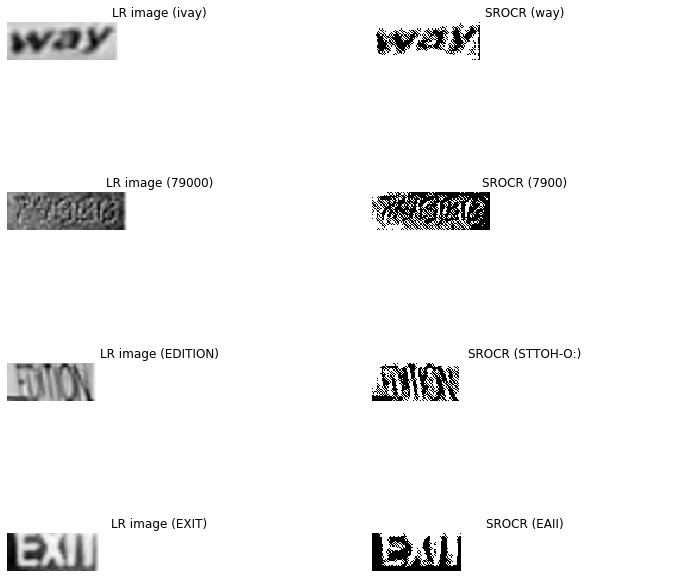

In [31]:
plot_srocr(SROCR_gen_10x,srocr_crnn_10x,'SROCR ')

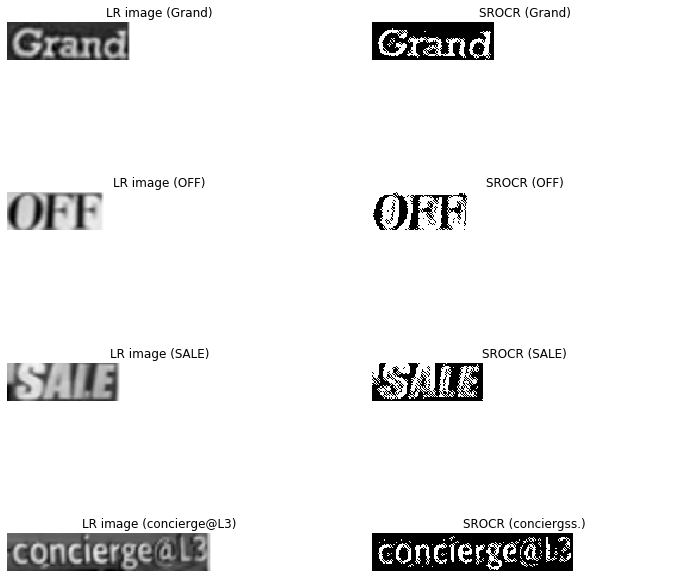

In [33]:
plot_srocr(SROCR_gen_10x,srocr_crnn_10x,'SROCR ')

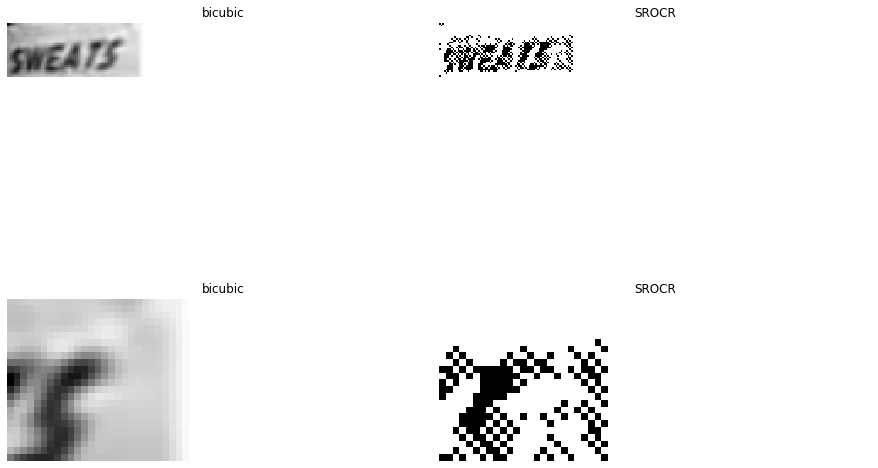

In [41]:
plot_gan_zoom(SROCR_gen_10x,'SROCR')

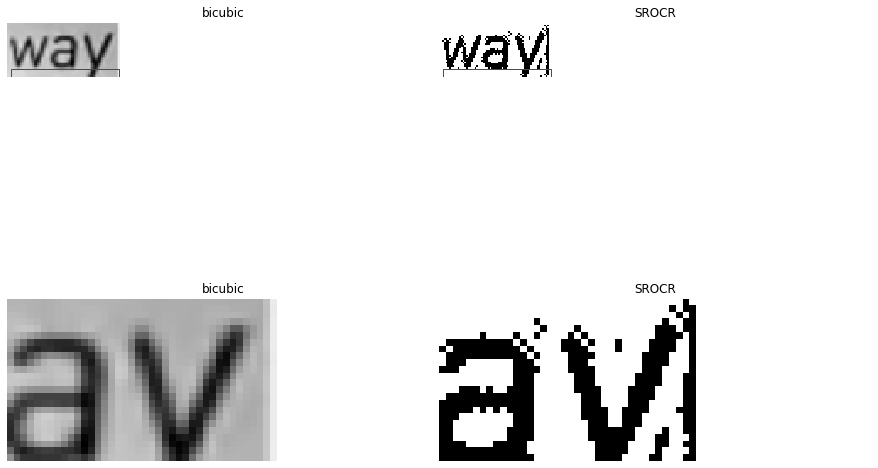

In [42]:
plot_gan_zoom(SROCR_gen_10x,'SROCR')

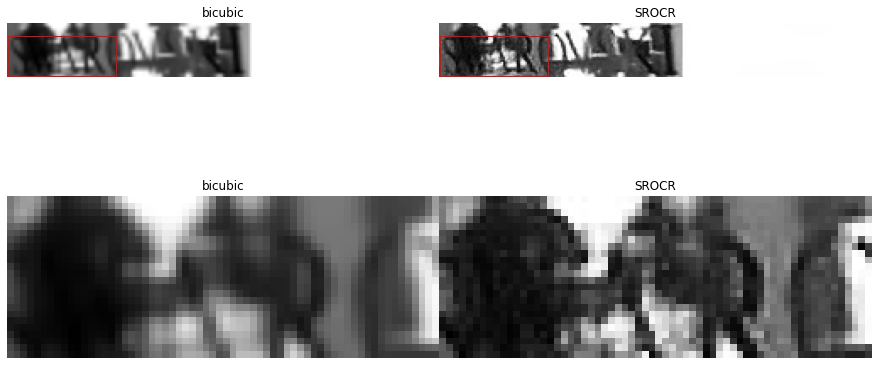

In [13]:
plot_gan_zoom(G_ocr,'SROCR')

# SROCR vs SRGAN

The following section shows comparison of output of SROCR generator and SRGAN generator.

In [17]:
def plot_gan_comp(G1,G2,G1_name,G2_name):
    n_imgs=4
    plt.figure(figsize=(18, 6))
    plt.tight_layout()
    for i in range(0, n_imgs * 3, 3):
        idx = np.random.randint(0, low_reso.shape[0] - 1)
        plt.subplot(n_imgs, 3, i + 1)
        plt.imshow(cv2.resize(low_reso[idx], (32, 256)).transpose(1,0),cmap='gray')
        plt.grid('off')
        plt.axis('off')
        plt.title('X2 (bicubic)')


        img = G1.predict(np.expand_dims(low_reso[idx], axis=0) / 127.5 - 1)
        img_unnorm = (img + 1) * 127.5
        img_gan = np.squeeze(img_unnorm, axis=0).astype(np.uint8)
        img_gan = np.squeeze(img_gan, axis=2)
        
        plt.subplot(n_imgs, 3, i + 2)
        plt.imshow(img_gan.transpose(1,0),cmap='gray')       
    
        plt.grid('off')
        plt.axis('off')
        plt.title(G1_name)
        
        img = G2.predict(np.expand_dims(low_reso[idx], axis=0) / 127.5 - 1)
        img_unnorm = (img + 1) * 127.5
        img_gan = np.squeeze(img_unnorm, axis=0).astype(np.uint8)
        img_gan = np.squeeze(img_gan, axis=2)
        
        plt.subplot(n_imgs, 3, i + 3)
        plt.imshow(img_gan.transpose(1,0),cmap='gray')        
    
        plt.grid('off')
        plt.axis('off')
        plt.title(G2_name)

In [18]:
G_srgan = srocr_gen([None,None, 1],2)
G_srgan.load_weights('generator_srgan.h5')


#### SROCR (learning rate from OCR = learning rate from SR)  

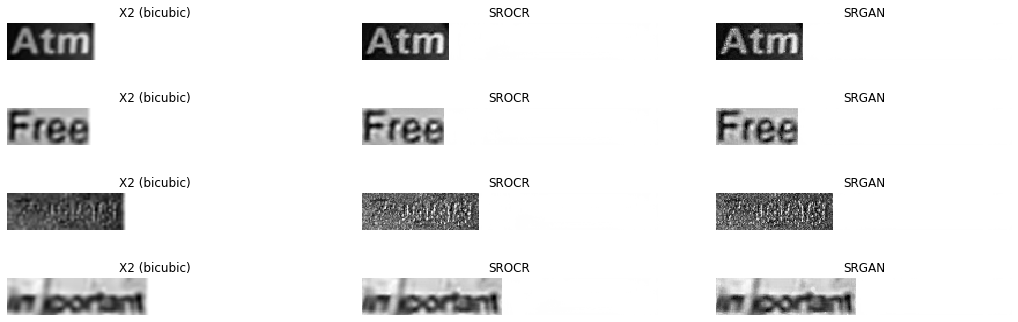

In [46]:
plot_gan_comp(SROCR_gen_1x,G_srgan,'SROCR','SRGAN')

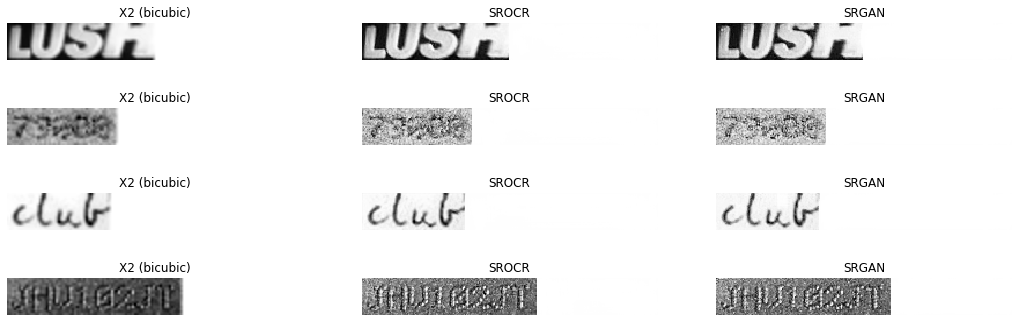

In [47]:
plot_gan_comp(SROCR_gen_1x,G_srgan,'SROCR','SRGAN')

#### SROCR (learning rate from OCR = 4 x learning rate from SR)  

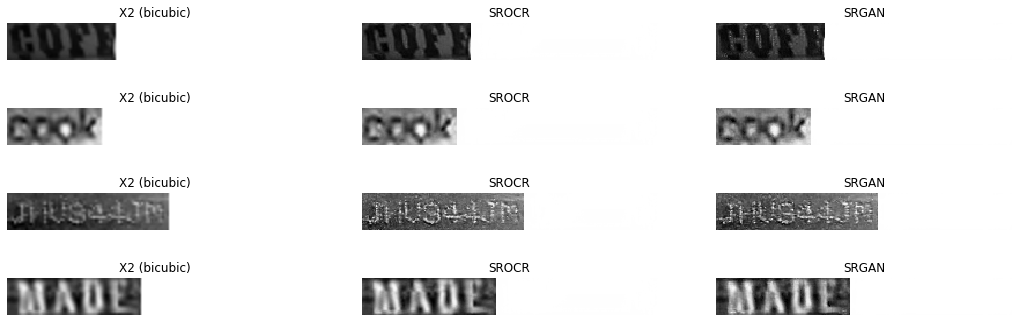

In [48]:
plot_gan_comp(SROCR_gen_4x,G_srgan,'SROCR','SRGAN')

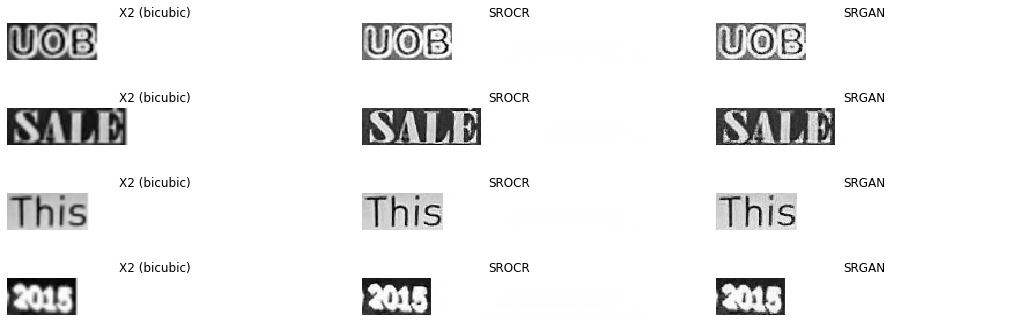

In [49]:
plot_gan_comp(SROCR_gen_4x,G_srgan,'SROCR','SRGAN')

#### SROCR (learning rate from OCR = 10 x learning rate from SR)  

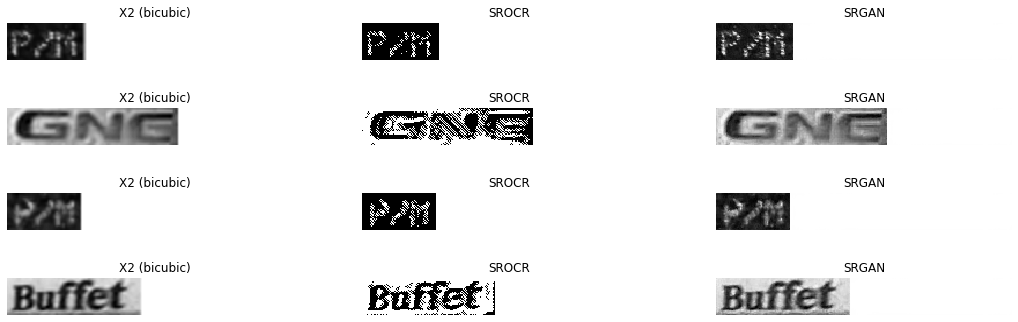

In [50]:
plot_gan_comp(SROCR_gen_10x,G_srgan,'SROCR','SRGAN')

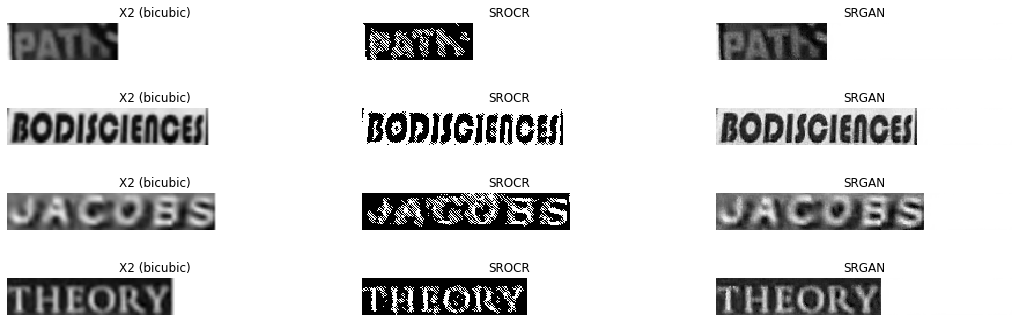

In [51]:
plot_gan_comp(SROCR_gen_10x,G_srgan,'SROCR','SRGAN')

# SROCR vs OCR

The following section shows comparison of the CRNN of SROCR  and CRNN trained on same dataset.

#### CRNN trained on low res images 

In [29]:
os.chdir('./crnn_low_res')

FileNotFoundError: [WinError 2] The system cannot find the file specified: './crnn_low_res'

In [30]:
import editdistance
import numpy as np


In [31]:
from crnn_lr_data_loader import load_data as crnn_lr_load_data
from crnn_lr_data_loader import alphabet as alphabet
from crnn_model import CRNN

In [32]:
imgs,labels,input_length,label_length,source_str = crnn_lr_load_data(imgdir,gtdir)
img_shape = (256, 32, 1)
crnn_lr = CRNN(img_shape, len(alphabet)) 
crnn_lr.load_weights('crnn_weights_epoch_500.h5') 

In [39]:
mean_ed = 0
mean_ed_norm = 0
mean_character_recogniton_rate = 0
sum_ed = 0
char_count = 0
correct_word_count = 0 

word_recognition_rate = 0
images_ = np.ones([1, 256, 32, 1])

In [40]:
j = 0
for idx in range(len(imgs)):

    
    images_[0] = imgs[idx]
    res = crnn_lr.predict(images_)

    for i in range(len(res)):
        j+=1
       
        # best path, real ocr applications use beam search with dictionary and language model
        chars = [alphabet[c] for c in np.argmax(res[i], axis=1)]
        gt_str = source_str[idx]
        res_str = decode(chars)
        
        ed = editdistance.eval(gt_str, res_str)
        #ed = levenshtein(gt_str, res_str)
        ed_norm = ed / len(gt_str)
        mean_ed += ed
        mean_ed_norm += ed_norm
        
        sum_ed += ed
        char_count += len(gt_str)
        if ed == 0.: correct_word_count += 1
        
        #print('%20s %20s %f' %(gt_str, res_str, ed))

mean_ed /= j
mean_ed_norm /= j
character_recogniton_rate = (char_count-sum_ed) / char_count
word_recognition_rate = correct_word_count / j

In [41]:
print()
print('mean editdistance             %0.3f' % (mean_ed))
print('mean normalized editdistance  %0.3f' % (mean_ed_norm))
print('character recogniton rate     %0.3f' % (character_recogniton_rate))
print('word recognition rate         %0.3f' % (word_recognition_rate))


mean editdistance             1.963
mean normalized editdistance  0.291
character recogniton rate     0.661
word recognition rate         0.467


#### CRNN trained on high res images 

In [42]:
os.chdir('../crnn_high_res')

In [43]:
from crnn_hr_data_loader import load_data as crnn_hr_load_data
from crnn_hr_data_loader import alphabet as alphabet
from crnn_model import CRNN

In [44]:
imgs,labels,input_length,label_length,source_str = crnn_hr_load_data(imgdir,gtdir)
img_shape = (256, 32, 1)
crnn_hr = CRNN(img_shape, len(alphabet)) 
crnn_hr.load_weights('crnn_weights_epoch_500.h5') 

In [45]:
mean_ed = 0
mean_ed_norm = 0
mean_character_recogniton_rate = 0
sum_ed = 0
char_count = 0
correct_word_count = 0 

word_recognition_rate = 0
images_ = np.ones([1, 256, 32, 1])

In [46]:
j = 0
for idx in range(len(imgs)):

    
    images_[0] = imgs[idx]
    res = crnn_hr.predict(images_)

    for i in range(len(res)):
        j+=1
       
        # best path, real ocr applications use beam search with dictionary and language model
        chars = [alphabet[c] for c in np.argmax(res[i], axis=1)]
        gt_str = source_str[idx]
        res_str = decode(chars)
        
        ed = editdistance.eval(gt_str, res_str)
        #ed = levenshtein(gt_str, res_str)
        ed_norm = ed / len(gt_str)
        mean_ed += ed
        mean_ed_norm += ed_norm
        
        sum_ed += ed
        char_count += len(gt_str)
        if ed == 0.: correct_word_count += 1
        
        #print('%20s %20s %f' %(gt_str, res_str, ed))

mean_ed /= j
mean_ed_norm /= j
character_recogniton_rate = (char_count-sum_ed) / char_count
word_recognition_rate = correct_word_count / j

In [47]:
print()
print('mean editdistance             %0.3f' % (mean_ed))
print('mean normalized editdistance  %0.3f' % (mean_ed_norm))
print('character recogniton rate     %0.3f' % (character_recogniton_rate))
print('word recognition rate         %0.3f' % (word_recognition_rate))


mean editdistance             1.735
mean normalized editdistance  0.260
character recogniton rate     0.700
word recognition rate         0.515


#### SROCR text recognition perfromance (learning rate of OCR = learning rate of SR)

In [48]:
os.chdir('..')

In [49]:
from data_loader import load_data
from data_loader import alphabet as alphabet
from crnn_model import CRNN

In [50]:
high_reso,low_reso,labels,input_length,label_length,source_str = load_data(imgdir,gtdir)

img_shape = (256, 32, 1)
srocr_1x_crnn = CRNN(img_shape, len(alphabet)) 
srocr_1x_crnn.load_weights('srocr_1xgen/crnn_srocr.h5') 

In [51]:

mean_ed = 0
mean_ed_norm = 0
mean_character_recogniton_rate = 0
sum_ed = 0
char_count = 0
correct_word_count = 0 

word_recognition_rate = 0
images_ = np.ones([1, 256, 32, 1])

In [52]:
j = 0
for idx in range(len(low_reso)):

    img_lr = low_reso[idx]
    img = SROCR_gen_1x.predict(np.expand_dims(img_lr, axis=0) / 127.5 - 1)
    img_unnorm = (img + 1) * 127.5
    res = srocr_1x_crnn.predict(img_unnorm)
    #images_[0] = low_reso[idx]
    #res = crnn.predict(images_)

    for i in range(len(res)):
        j+=1
       
        # best path, real ocr applications use beam search with dictionary and language model
        chars = [alphabet[c] for c in np.argmax(res[i], axis=1)]
        gt_str = source_str[idx]
        res_str = decode(chars)
        
        ed = editdistance.eval(gt_str, res_str)
        #ed = levenshtein(gt_str, res_str)
        ed_norm = ed / len(gt_str)
        mean_ed += ed
        mean_ed_norm += ed_norm
        
        sum_ed += ed
        char_count += len(gt_str)
        if ed == 0.: correct_word_count += 1
        
        #print('%20s %20s %f' %(gt_str, res_str, ed))

mean_ed /= j
mean_ed_norm /= j
character_recogniton_rate = (char_count-sum_ed) / char_count
word_recognition_rate = correct_word_count / j

In [53]:
print()
print('mean editdistance             %0.3f' % (mean_ed))
print('mean normalized editdistance  %0.3f' % (mean_ed_norm))
print('character recogniton rate     %0.3f' % (character_recogniton_rate))
print('word recognition rate         %0.3f' % (word_recognition_rate))


mean editdistance             1.927
mean normalized editdistance  0.289
character recogniton rate     0.667
word recognition rate         0.456


#### SROCR text recognition perfromance (learning rate of OCR = 4 x learning rate of SR)

In [54]:
img_shape = (256, 32, 1)
srocr_4x_crnn = CRNN(img_shape, len(alphabet)) 
srocr_4x_crnn.load_weights('srocr_4xgen/crnn_srocr.h5') 

In [55]:

mean_ed = 0
mean_ed_norm = 0
mean_character_recogniton_rate = 0
sum_ed = 0
char_count = 0
correct_word_count = 0 

word_recognition_rate = 0
images_ = np.ones([1, 256, 32, 1])

In [56]:
j = 0
for idx in range(len(low_reso)):

    img_lr = low_reso[idx]
    img = SROCR_gen_4x.predict(np.expand_dims(img_lr, axis=0) / 127.5 - 1)
    img_unnorm = (img + 1) * 127.5
    res = srocr_4x_crnn.predict(img_unnorm)
    #images_[0] = low_reso[idx]
    #res = crnn.predict(images_)

    for i in range(len(res)):
        j+=1
       
        # best path, real ocr applications use beam search with dictionary and language model
        chars = [alphabet[c] for c in np.argmax(res[i], axis=1)]
        gt_str = source_str[idx]
        res_str = decode(chars)
        
        ed = editdistance.eval(gt_str, res_str)
        #ed = levenshtein(gt_str, res_str)
        ed_norm = ed / len(gt_str)
        mean_ed += ed
        mean_ed_norm += ed_norm
        
        sum_ed += ed
        char_count += len(gt_str)
        if ed == 0.: correct_word_count += 1
        
        #print('%20s %20s %f' %(gt_str, res_str, ed))

mean_ed /= j
mean_ed_norm /= j
character_recogniton_rate = (char_count-sum_ed) / char_count
word_recognition_rate = correct_word_count / j

In [57]:
print()
print('mean editdistance             %0.3f' % (mean_ed))
print('mean normalized editdistance  %0.3f' % (mean_ed_norm))
print('character recogniton rate     %0.3f' % (character_recogniton_rate))
print('word recognition rate         %0.3f' % (word_recognition_rate))


mean editdistance             1.911
mean normalized editdistance  0.287
character recogniton rate     0.670
word recognition rate         0.464


#### SROCR text recognition perfromance (learning rate of OCR = 10 x learning rate of SR)

In [58]:
img_shape = (256, 32, 1)
srocr_10x_crnn = CRNN(img_shape, len(alphabet)) 
srocr_10x_crnn.load_weights('srocr_10xgen/crnn_srocr.h5') 

In [59]:

mean_ed = 0
mean_ed_norm = 0
mean_character_recogniton_rate = 0
sum_ed = 0
char_count = 0
correct_word_count = 0 

word_recognition_rate = 0
images_ = np.ones([1, 256, 32, 1])

In [60]:
j = 0
for idx in range(len(low_reso)):

    img_lr = low_reso[idx]
    img = SROCR_gen_10x.predict(np.expand_dims(img_lr, axis=0) / 127.5 - 1)
    img_unnorm = (img + 1) * 127.5
    res = srocr_10x_crnn.predict(img_unnorm)
    #images_[0] = low_reso[idx]
    #res = crnn.predict(images_)

    for i in range(len(res)):
        j+=1
       
        # best path, real ocr applications use beam search with dictionary and language model
        chars = [alphabet[c] for c in np.argmax(res[i], axis=1)]
        gt_str = source_str[idx]
        res_str = decode(chars)
        
        ed = editdistance.eval(gt_str, res_str)
        #ed = levenshtein(gt_str, res_str)
        ed_norm = ed / len(gt_str)
        mean_ed += ed
        mean_ed_norm += ed_norm
        
        sum_ed += ed
        char_count += len(gt_str)
        if ed == 0.: correct_word_count += 1
        
        #print('%20s %20s %f' %(gt_str, res_str, ed))

mean_ed /= j
mean_ed_norm /= j
character_recogniton_rate = (char_count-sum_ed) / char_count
word_recognition_rate = correct_word_count / j

In [61]:
print()
print('mean editdistance             %0.3f' % (mean_ed))
print('mean normalized editdistance  %0.3f' % (mean_ed_norm))
print('character recogniton rate     %0.3f' % (character_recogniton_rate))
print('word recognition rate         %0.3f' % (word_recognition_rate))


mean editdistance             2.675
mean normalized editdistance  0.391
character recogniton rate     0.538
word recognition rate         0.402
